In [126]:
import torch
import os
import numpy as np
from PIL import Image
import pandas as pd
import torchvision
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, dataset
import torchtext
from torch.nn.functional import one_hot
import torch.optim as optim

import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [12, 30]
#plt.rcParams['figure.dpi'] = 100



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is", device)

device is cpu


In [127]:
class CaptionDataset(torch.utils.data.Dataset):
    def __init__(self, dir, length,num,transform=None):
        self.transform = transform
        self.image_dir = os.path.join(dir,"Images")
        self.df = pd.read_csv(os.path.join(dir,"captions.txt"))

        self.length = length
        
        self.tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
        self.vocab = torchtext.vocab.build_vocab_from_iterator(
            self.tokenizer(caption) for caption in self.df["caption"][0:num]
        )
        self.vocab.append_token("<start>")
        self.vocab.append_token("<end>")
        self.vocab.append_token("<pad>")
        print(self.vocab.get_stoi())

        #Finds incdicies of <start>, <end>, <pad>
        self.special_indices = self.vocab.lookup_indices(["<start>","<end>","<pad>"])
        print(self.special_indices)

        self.df2 = pd.DataFrame(columns=['image','caption','length'])

        for i, (image, caption) in enumerate(zip(self.df['image'],self.df['caption'])):
            if i%1000==0:
                print(i)
            tokens = self.tokenizer(caption)
            tokens[:0] = ["<start>"]
            tokens.append("<end>")
            if len(tokens)>length:
                continue
            length2 = len(tokens)
            while len(tokens)<length:
                tokens.append("<pad>")

            tokens_num = torch.tensor([self.vocab[token] for token in tokens])
            self.df2.loc[-1] = [image,tokens_num,length2]  # adding a row
            self.df2.index = self.df2.index + 1  # shifting index
            self.df2 = self.df2.sort_index()  # sorting by index
            
            if (i==num-1):
                break



    def __getitem__(self,i):
        caption = self.df2["caption"][i]
        image_path = os.path.join(self.image_dir,self.df2["image"][i])
        image = transforms.ToTensor()(Image.open(image_path))
        if self.transform!=None:
            image = self.transform(image)
        return (image,caption)

    def __len__(self):
        return len(self.df2)

In [128]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [129]:
ds = CaptionDataset("archive",30,500,transform=preprocess)
#ds,awd = torch.utils.data.random_split(ds, [int(len(ds)*0.1),len(ds)-int(len(ds)*0.1)])
#vocab_builder = DataLoader(ds,batch_size=1)
#vocab_it = iter(vocab_builder)

#tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
#vocab = torchtext.vocab.build_vocab_from_iterator(
#    tokenizer(caption[1][0]) for caption in vocab_it
#)
dl = DataLoader(ds,batch_size=8,shuffle=True)

{'the': 2, 'face': 134, 'baked': 452, 'small': 58, 'group': 56, 'a': 0, 'hose': 193, 'running': 29, 'around': 100, 'wooded': 813, 'yellow': 45, 'dog': 5, 'open': 365, 'with': 9, 'after': 146, 'door': 324, '.': 1, 'white': 15, 'an': 24, 'breeds': 305, 'outfit': 651, 'and': 7, 'traffic': 289, 'soccer': 212, 'in': 3, 'stands': 59, 'whilst': 428, 'cavern': 484, 'water': 21, 'on': 4, 'standing': 55, 'down': 35, 'snowmobiles': 210, 'playing': 32, 'other': 99, 'fountain': 116, 'pedaling': 667, 'woman': 18, 'appears': 439, 'is': 6, 'stump': 755, 'courtyard': 316, 'of': 8, 'bike': 149, 'being': 175, 'sitting': 48, 'cart': 311, 'near': 40, 'man': 10, 'horses': 121, 'brown': 27, 'slides': 398, 'together': 219, 'uses': 792, 'boy': 11, 'taxi': 770, 'two': 12, 'hikers': 192, 'handrail': 571, 'beach': 25, 'next': 66, 'at': 13, 'ball': 46, 'all': 435, 'or': 650, 'to': 19, 'black': 14, 'jeans': 350, 'boston': 229, 'blue': 26, 'are': 16, 'pushing': 689, 'frisbee': 554, 'corgi': 502, 'into': 53, 'three':

In [130]:
it = iter(dl)

In [131]:
next(it)

[tensor([[[[-2.0837, -2.1008, -2.1008,  ..., -2.0665, -2.0152, -1.9638],
           [-2.0837, -2.0837, -2.0837,  ..., -1.9809, -1.9295, -1.9295],
           [-2.0837, -2.0837, -2.1008,  ..., -1.8953, -1.8610, -1.8439],
           ...,
           [-1.9980, -2.0152, -1.9809,  ..., -2.0152, -2.0152, -2.0152],
           [-1.9980, -1.9980, -2.0152,  ..., -1.9980, -2.0152, -2.0152],
           [-2.0152, -2.0323, -2.0152,  ..., -2.0152, -2.0152, -1.9980]],
 
          [[-2.0007, -2.0182, -2.0182,  ..., -1.9832, -1.9307, -1.8957],
           [-2.0007, -2.0007, -2.0007,  ..., -1.9132, -1.8256, -1.8256],
           [-2.0007, -2.0007, -2.0182,  ..., -1.8431, -1.8256, -1.8431],
           ...,
           [-1.9307, -1.9307, -1.9132,  ..., -1.9307, -1.9307, -1.9307],
           [-1.9307, -1.9132, -1.9307,  ..., -1.9132, -1.9307, -1.9307],
           [-1.9482, -1.9482, -1.9307,  ..., -1.9307, -1.9307, -1.9132]],
 
          [[-1.7696, -1.7870, -1.7870,  ..., -1.7696, -1.7173, -1.6824],
           [-

In [132]:
print(ds.df2["caption"])
print(ds.df2["length"])
print(len(ds.vocab))

0      [tensor(818), tensor(218), tensor(6), tensor(0...
1      [tensor(818), tensor(17), tensor(9), tensor(70...
2      [tensor(818), tensor(0), tensor(22), tensor(17...
3      [tensor(818), tensor(0), tensor(22), tensor(17...
4      [tensor(818), tensor(0), tensor(30), tensor(17...
                             ...                        
495    [tensor(818), tensor(0), tensor(30), tensor(17...
496    [tensor(818), tensor(0), tensor(30), tensor(17...
497    [tensor(818), tensor(0), tensor(30), tensor(17...
498    [tensor(818), tensor(0), tensor(17), tensor(33...
499    [tensor(818), tensor(0), tensor(39), tensor(3)...
Name: caption, Length: 500, dtype: object
0      10
1      13
2      11
3      14
4      16
       ..
495    15
496    12
497    11
498    10
499    20
Name: length, Length: 500, dtype: int64
821


In [133]:
from torchsummary import summary

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet101(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.dem_red1 = nn.Conv2d(2048, 1024, kernel_size=1, padding=0)
        self.dem_red2 = nn.Conv2d(1024, 512, kernel_size=1, padding=0)
        self.fc1 = nn.Linear(512*7*7,500)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(500,100)

    def forward(self,x):
        x = self.resnet(x)
        x = self.act(x)
        x = self.dem_red1(x)
        x = self.act(x)
        x = self.dem_red2(x)
        x = self.act(x)
        x = torch.flatten(x,start_dim=1)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

model = Encoder()

summary(model, (3, 224, 224))


C:\Users\Anton\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Anton\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [134]:
class Decoder(nn.Module):
    #LSTM
    def __init__(self, embedding_dim, encoded_dim, vocab_size, output_length):
        super().__init__()
        self.hidden_dim = encoded_dim
        self.vocab_size = vocab_size
        self.output_length = output_length

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTMCell(embedding_dim, encoded_dim)
        self.linear = nn.Linear(encoded_dim, vocab_size)

    def forward(self, start_word, h0):
        word = self.embeddings(start_word)
        hx = h0
        cx = h0
        outputs = torch.clone(one_hot(start_word,self.vocab_size))
        word = torch.squeeze(word,1)
        while outputs.size(1)<self.output_length:
            hx, cx = self.lstm(word, (hx, cx))
            word = self.linear(hx)
            outputs = torch.cat((outputs,torch.unsqueeze(word,dim=1)),dim=1)
            word = self.embeddings(torch.argmax(word,dim=1))
        return outputs

#d = Decoder(10,10,15)
#start = (torch.unsqueeze(torch.ones(13),1)*14).to(torch.int64)
#print(start)
#print(start.shape)
#enc = torch.rand(13,10)
#print(enc)
#print(enc.shape)
#o = d(start,enc)
#print(o)
#print(o.shape)
#lab = torch.randint(0,15,(13,3))
#lab = one_hot(lab).to(torch.float)
#print(lab.shape)
#criterion = nn.CrossEntropyLoss()
#loss = criterion(o,lab)
#print(loss)
#loss.backward()

In [135]:
def train(encoder, decoder, optimizer, criterion, loader, epochs, start_token_idx):
    for epoch in range(epochs):
        print("Processing Epoch:",epoch)
        for batch_nr, (image, label) in enumerate(loader):
            print("Starting batch:", batch_nr)
            # Forward pass
            img = encoder(image)

            start_tokens = (torch.unsqueeze(torch.ones(label.size(0)),1)*start_token_idx).to(torch.int64)

            pred = decoder(start_tokens, img)
            label = one_hot(label).to(torch.float)

            #Backwards pass
            optimizer.zero_grad()
            loss = criterion(pred,label)
            print(loss.item())
            loss.backward()
            optimizer.step()


In [136]:
LEARNING_RATE = 0.0001
EPOCHS = 100

encoder = Encoder()
decoder = Decoder(60,100,len(ds.vocab),30)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LEARNING_RATE)

train(encoder,decoder,optimizer,criterion,dl,EPOCHS,ds.special_indices[0])


Processing Epoch: 0
Starting batch: 0
0.12341243773698807
Starting batch: 1
0.12312863022089005
Starting batch: 2
0.1229957565665245
Starting batch: 3
0.12219225615262985
Starting batch: 4
0.1220666691660881
Starting batch: 5
0.12077782303094864
Starting batch: 6
0.12005336582660675
Starting batch: 7
0.12045349180698395
Starting batch: 8
0.12077099084854126
Starting batch: 9
0.11981042474508286
Starting batch: 10
0.12011841684579849
Starting batch: 11
0.12022791802883148
Starting batch: 12
0.11762134730815887
Starting batch: 13
0.11852482706308365
Starting batch: 14
0.11835651844739914
Starting batch: 15
0.11787885427474976
Starting batch: 16
0.11778108775615692
Starting batch: 17
0.11814668774604797
Starting batch: 18
0.11876843124628067
Starting batch: 19
0.1169596016407013
Starting batch: 20
0.1177784651517868
Starting batch: 21
0.11671718955039978
Starting batch: 22
0.11765661090612411
Starting batch: 23
0.11738564074039459
Starting batch: 24
0.11587708443403244
Starting batch: 25


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 30])
torch.Size([8, 30])
['<start>', 'a', 'shirtless', 'man', 'and', 'a', 'woman', 'sitting', 'on', 'a', 'dock', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'child', 'in', 'in', 'in', 'a', 'a', 'a', 'a', '<end>', '.', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


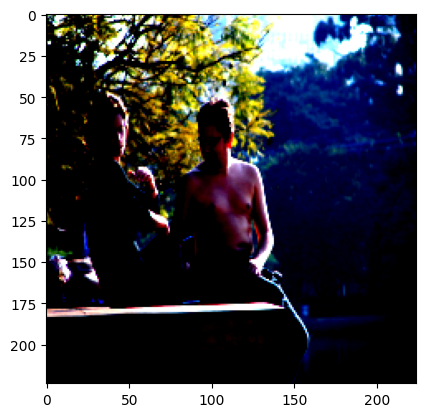

In [137]:
img, label = next(it)
plt.imshow(img[0].permute(1, 2, 0))
img = encoder(img)
start_tokens = (torch.unsqueeze(torch.ones(label.size(0)),1)*ds.special_indices[0]).to(torch.int64)
pred = torch.argmax(decoder(start_tokens, img),dim=2)
print(pred.shape)
print(label.shape)
print(ds.vocab.lookup_tokens(label[0].tolist()))
print(ds.vocab.lookup_tokens(pred[0].tolist()))